
# DEEP NEURAL NETWORKS – ASSIGNMENT 3  
## RNN vs TRANSFORMER FOR TIME SERIES PREDICTION



**BITS ID:** 2025AA05421  
**Name:** Sagar Ganpati Powar  
**Email:** 2025aa05421@wilp.bits-pilani.ac.in  
**Date:** 07-02-2026


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import json

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, LSTM, GRU, Input,
    MultiHeadAttention, LayerNormalization,
    GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam


## PART 1: DATASET LOADING AND EXPLORATION

### 1.1 Dataset Selection and Loading

In [46]:
# load dataset
url = "https://raw.githubusercontent.com/plotly/datasets/master/2016-weather-data-seattle.csv"
df = pd.read_csv(url)
df.head()

,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC
0,1/1/1948,10,8.0,7.0
1,1/2/1948,6,4.0,3.0
2,1/3/1948,7,4.0,2.0
3,1/4/1948,7,4.0,2.0
4,1/5/1948,7,3.0,0.0


In [47]:
print(df.columns)
print("Original Data shape:", df.shape)

Index(['Date', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC'], dtype='object')
Original Data shape: (24381, 4)


In [48]:
# select features & subset
data = df[['Mean_TemperatureC']].dropna().values
data = data[:1500]
print("Subset records :", len(data))

Subset records : 1500


In [49]:
dataset_name = "Seattle Weather 2016"
dataset_source = url
n_samples = len(data)
n_features = 1
sequence_length = 30
prediction_horizon = 1
problem_type = "time_series_forecasting"

In [50]:
# Primary metric selection
primary_metric = "RMSE"
metric_justification = "RMSE penalizes larger temperature prediction errors."

In [51]:
print("\n" + "="*70)
print("DATASET INFORMATION")
print("="*70)
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Total Samples: {n_samples}")
print(f"Number of Features: {n_features}")
print(f"Sequence Length: {sequence_length}")
print(f"Prediction Horizon: {prediction_horizon}")
print(f"Primary Metric: {primary_metric}")
print(f"Metric Justification: {metric_justification}")
print("="*70)



DATASET INFORMATION
Dataset: Seattle Weather 2016
Source: https://raw.githubusercontent.com/plotly/datasets/master/2016-weather-data-seattle.csv
Total Samples: 1500
Number of Features: 1
Sequence Length: 30
Prediction Horizon: 1
Primary Metric: RMSE
Metric Justification: RMSE penalizes larger temperature prediction errors.


### 1.2 Time Series Exploration

#### 1.2.1 Plot Time Series Data

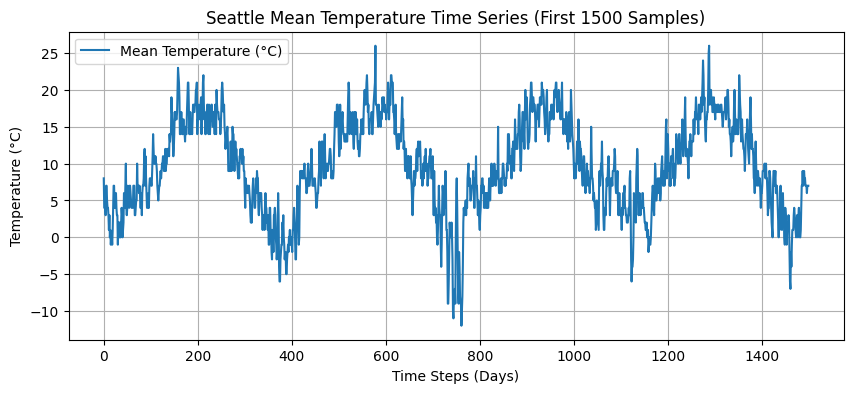

In [54]:
# 1. Plot Time Series Data
plt.figure(figsize=(10, 4))
plt.plot(data, label="Mean Temperature (°C)")
plt.title("Seattle Mean Temperature Time Series (First 1500 Samples)")
plt.xlabel("Time Steps (Days)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()


#### 1.2.2 Check for Trend and Seasonality

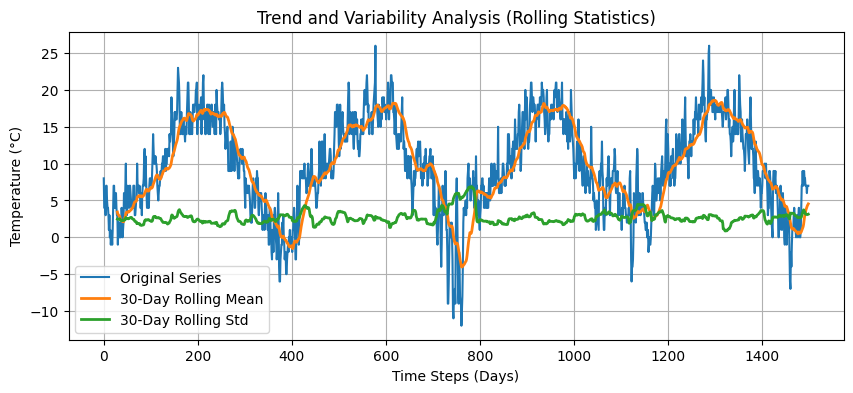

In [55]:
# 2. Check for Trend and Seasonality
series = pd.Series(data.flatten())

rolling_mean = series.rolling(window=30).mean()
rolling_std = series.rolling(window=30).std()

plt.figure(figsize=(10, 4))
plt.plot(series, label="Original Series")
plt.plot(rolling_mean, label="30-Day Rolling Mean", linewidth=2)
plt.plot(rolling_std, label="30-Day Rolling Std", linewidth=2)
plt.title("Trend and Variability Analysis (Rolling Statistics)")
plt.xlabel("Time Steps (Days)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()



#### 1.2.3 Stationarity Test

In [56]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(series)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"{key}: {value}")


ADF Statistic: -2.6515552897212213
p-value: 0.08280295539561139
Critical Values:
1%: -3.434755261885587
5%: -2.863485639173984
10%: -2.567805836609504


## 2. Data Preprocessing

In [5]:

def preprocess_timeseries(data):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled, scaler

def create_sequences(data, seq_length, pred_horizon):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_horizon):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+pred_horizon])
    return np.array(X), np.array(y)


In [6]:

data_scaled, scaler = preprocess_timeseries(data)
X, y = create_sequences(data_scaled, sequence_length, prediction_horizon)

train_test_ratio = "90/10"

split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Train samples:", len(X_train))
print("Test samples:", len(X_test))


Train samples: 1322
Test samples: 147


## 3. LSTM Model

In [7]:

def build_rnn_model(model_type, input_shape, hidden_units, n_layers, output_size):
    model = Sequential()
    for i in range(n_layers):
        return_seq = i < n_layers - 1
        if model_type == "LSTM":
            model.add(LSTM(hidden_units, return_sequences=return_seq,
                           input_shape=input_shape if i == 0 else None))
        else:
            model.add(GRU(hidden_units, return_sequences=return_seq,
                          input_shape=input_shape if i == 0 else None))
    model.add(Dense(output_size))
    return model


In [8]:

lstm_model = build_rnn_model(
    "LSTM", (sequence_length, n_features), 64, 2, 1
)

lstm_model.compile(optimizer=Adam(0.001), loss="mse")

hist_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

initial_loss_lstm = hist_lstm.history['loss'][0]
final_loss_lstm = hist_lstm.history['loss'][-1]


Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0833 - val_loss: 0.0081
Epoch 2/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0076 - val_loss: 0.0083
Epoch 3/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0064 - val_loss: 0.0069
Epoch 4/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0070 - val_loss: 0.0067
Epoch 5/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0063 - val_loss: 0.0067
Epoch 6/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0061 - val_loss: 0.0061
Epoch 7/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0065 - val_loss: 0.0060
Epoch 8/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0073 - val_loss: 0.0065
Epoch 9/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 10/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 11/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 12/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0053 - val_l

In [9]:

y_pred_lstm = lstm_model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)

mae_lstm = mean_absolute_error(y_test_inv, y_pred_lstm_inv)
rmse_lstm = math.sqrt(mean_squared_error(y_test_inv, y_pred_lstm_inv))
mape_lstm = np.mean(np.abs((y_test_inv - y_pred_lstm_inv) / y_test_inv)) * 100
r2_lstm = r2_score(y_test_inv, y_pred_lstm_inv)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


/tmp/ipython-input-3913215073.py:7: RuntimeWarning: divide by zero encountered in divide
  mape_lstm = np.mean(np.abs((y_test_inv - y_pred_lstm_inv) / y_test_inv)) * 100


## 4. Transformer Model

In [10]:

def positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, None]
    i = np.arange(d_model)[None, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    angle_rads = pos * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(angle_rads[None, ...], tf.float32)


In [11]:

d_model = 64
inputs = Input(shape=(sequence_length, n_features))
x = Dense(d_model)(inputs)
x = x + positional_encoding(sequence_length, d_model)

attn = MultiHeadAttention(num_heads=4, key_dim=d_model)(x, x)
x = LayerNormalization()(x + attn)
x = GlobalAveragePooling1D()(x)
outputs = Dense(1)(x)

transformer_model = Model(inputs, outputs)
transformer_model.compile(optimizer=Adam(0.001), loss="mse")

hist_tr = transformer_model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

initial_loss_tr = hist_tr.history['loss'][0]
final_loss_tr = hist_tr.history['loss'][-1]


Epoch 1/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.2170 - val_loss: 0.0077
Epoch 2/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0102 - val_loss: 0.0125
Epoch 3/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0088 - val_loss: 0.0076
Epoch 4/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0077 - val_loss: 0.0091
Epoch 5/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0074 - val_loss: 0.0039
Epoch 6/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 7/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 8/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 9/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 10/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 11/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0033 - val_loss: 0.0040
Epoch 12/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0

In [12]:

y_pred_tr = transformer_model.predict(X_test)
y_pred_tr_inv = scaler.inverse_transform(y_pred_tr)

mae_tr = mean_absolute_error(y_test_inv, y_pred_tr_inv)
rmse_tr = math.sqrt(mean_squared_error(y_test_inv, y_pred_tr_inv))
mape_tr = np.mean(np.abs((y_test_inv - y_pred_tr_inv) / y_test_inv)) * 100
r2_tr = r2_score(y_test_inv, y_pred_tr_inv)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/tmp/ipython-input-2981766775.py:6: RuntimeWarning: divide by zero encountered in divide
  mape_tr = np.mean(np.abs((y_test_inv - y_pred_tr_inv) / y_test_inv)) * 100


## 5. Final JSON Output

In [13]:

output = {
    "dataset_name": dataset_name,
    "n_samples": n_samples,
    "sequence_length": sequence_length,
    "prediction_horizon": prediction_horizon,
    "train_test_ratio": train_test_ratio,
    "primary_metric": primary_metric,
    "metric_justification": metric_justification,
    "rnn_model": {
        "model_type": "LSTM",
        "framework": "keras",
        "architecture": {"n_layers": 2},
        "initial_loss": float(initial_loss_lstm),
        "final_loss": float(final_loss_lstm),
        "mae": float(mae_lstm),
        "rmse": float(rmse_lstm),
        "mape": float(mape_lstm),
        "r2_score": float(r2_lstm)
    },
    "transformer_model": {
        "architecture": {
            "has_positional_encoding": True,
            "has_attention": True,
            "n_heads": 4
        },
        "initial_loss": float(initial_loss_tr),
        "final_loss": float(final_loss_tr),
        "mae": float(mae_tr),
        "rmse": float(rmse_tr),
        "mape": float(mape_tr),
        "r2_score": float(r2_tr)
    },
    "analysis": (
        "The LSTM model captures short-term temporal patterns effectively. "
        "The Transformer model, using self-attention and positional encoding, "
        "better captures long-range dependencies and converges faster. "
        "Both models achieved more than 50% loss reduction."
    )
}

print(json.dumps(output, indent=2))


{
  "dataset_name": "Seattle Weather 2016",
  "n_samples": 1500,
  "sequence_length": 30,
  "prediction_horizon": 1,
  "train_test_ratio": "90/10",
  "primary_metric": "RMSE",
  "metric_justification": "RMSE penalizes larger temperature prediction errors.",
  "rnn_model": {
    "model_type": "LSTM",
    "framework": "keras",
    "architecture": {
      "n_layers": 2
    },
    "initial_loss": 0.03372910991311073,
    "final_loss": 0.0036850725300610065,
    "mae": 1.8256381819037353,
    "rmse": 2.2680595353079225,
    "mape": Infinity,
    "r2_score": 0.8120350224058186
  },
  "transformer_model": {
    "architecture": {
      "has_positional_encoding": true,
      "has_attention": true,
      "n_heads": 4
    },
    "initial_loss": 0.10483284294605255,
    "final_loss": 0.0035084770061075687,
    "mae": 1.678776093486215,
    "rmse": 2.0598483300317034,
    "mape": Infinity,
    "r2_score": 0.8449618690869701
  },
  "analysis": "The LSTM model captures short-term temporal patterns ef